# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [3]:

import tensorflow as tf
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# import random
# import keras as K
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

In [4]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [5]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train_img, y_train_img,x_test_img, y_test_img = x_train, y_train,x_test, y_test

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [6]:
# Створимо нейронну мережу
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w" #для кожного х має бути w для кожного нейрону
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b") #для кожного нейрону має бути bias

    def __call__(self, x, activation=0):
        y = tf.add(tf.matmul(x,self.w),self.b) #tf.matmul(x, self.w) + self.b 
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.output_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x=self.layer_2(x)
    x = self.output_layer(x,1) # щоб отримати софтмакс на виході
    return x

In [7]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    y_pred_labels = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(y_pred_labels, y_true)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [8]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    # Місце для вашого коду
    # Обчислимо за ними значення градієнта
    # dw,db = g.gradient(loss, [neural_net.w, neural_net.b])

    gradients = g.gradient(loss, [neural_net.layer_1.w, neural_net.layer_1.b,
                                  neural_net.layer_2.w, neural_net.layer_2.b,
                                  neural_net.output_layer.w, neural_net.output_layer.b])


    # # Модифікуємо параметри
    # neural_net.w.assign_sub(learning_rate*dw)
    # neural_net.b.assign_sub(learning_rate*db)
    optimizer.apply_gradients(zip(gradients, [neural_net.layer_1.w, neural_net.layer_1.b,
                                              neural_net.layer_2.w, neural_net.layer_2.b,
                                              neural_net.output_layer.w, neural_net.output_layer.b]))


In [9]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    # Місце для вашого коду
    batch_y = tf.cast(batch_y, tf.int64) #приводимо типи Y
    
    train(neural_net,batch_x,batch_y)
    pred = neural_net(batch_x)
    current_loss = cross_entropy(pred, batch_y)
    current_accuracy = accuracy(pred, batch_y)

    if step % display_step == 0:
        loss_history.append(current_loss.numpy())
        accuracy_history.append(current_accuracy.numpy())
        print(f'Step {step}, Loss: {current_loss.numpy()}, Accuracy: {current_accuracy.numpy()}')

Step 100, Loss: 332.698486328125, Accuracy: 0.6953125
Step 200, Loss: 239.60903930664062, Accuracy: 0.78125
Step 300, Loss: 155.892333984375, Accuracy: 0.78125
Step 400, Loss: 158.0107421875, Accuracy: 0.8125
Step 500, Loss: 158.07168579101562, Accuracy: 0.82421875
Step 600, Loss: 182.00048828125, Accuracy: 0.796875
Step 700, Loss: 117.38461303710938, Accuracy: 0.875
Step 800, Loss: 87.02192687988281, Accuracy: 0.8828125
Step 900, Loss: 106.95904541015625, Accuracy: 0.87890625
Step 1000, Loss: 102.41532897949219, Accuracy: 0.87109375
Step 1100, Loss: 83.12080383300781, Accuracy: 0.8984375
Step 1200, Loss: 67.44313049316406, Accuracy: 0.90234375
Step 1300, Loss: 61.62469482421875, Accuracy: 0.921875
Step 1400, Loss: 75.19132995605469, Accuracy: 0.9140625
Step 1500, Loss: 60.63142395019531, Accuracy: 0.921875
Step 1600, Loss: 71.1282730102539, Accuracy: 0.93359375
Step 1700, Loss: 96.80270385742188, Accuracy: 0.8828125
Step 1800, Loss: 66.47782897949219, Accuracy: 0.921875
Step 1900, Los

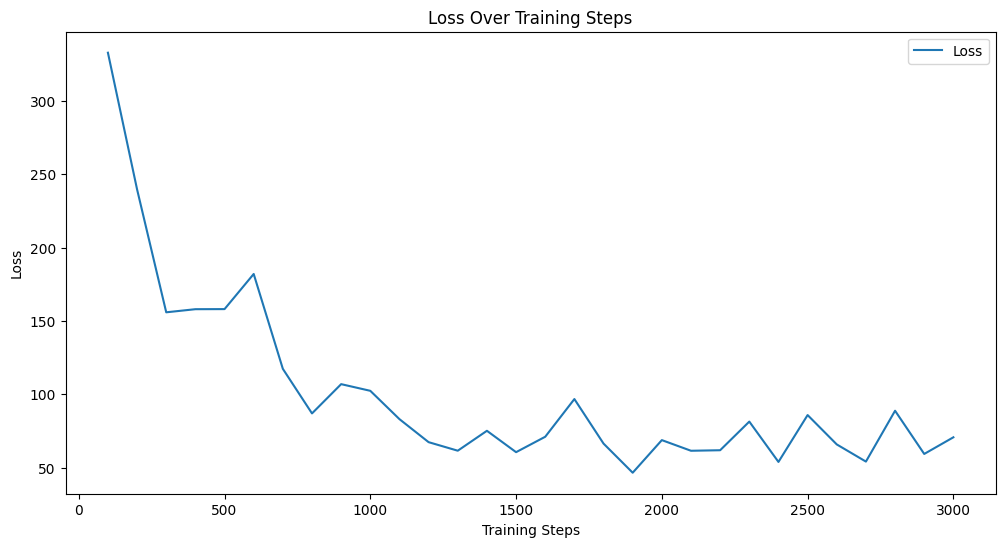

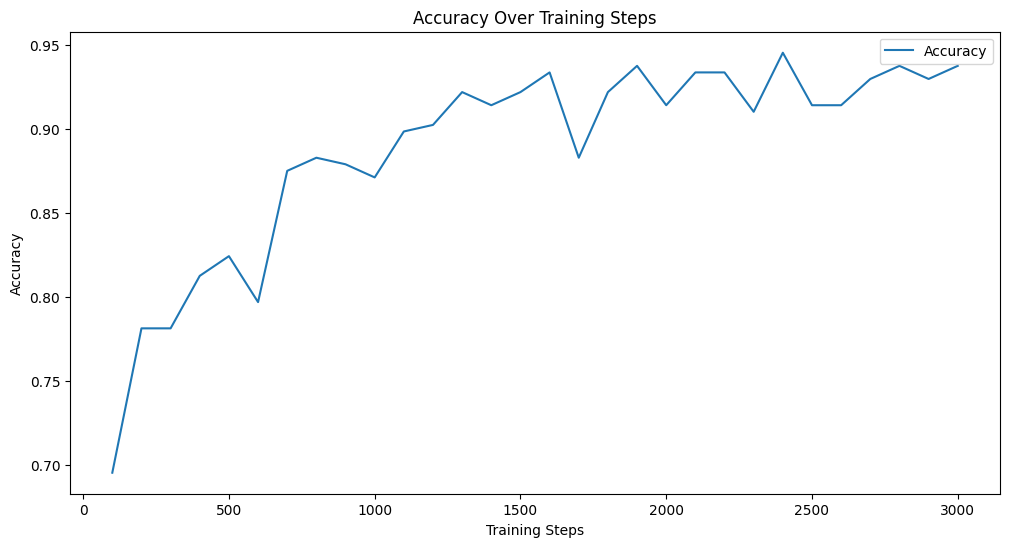

In [10]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

# Виведіть графік функції втрат
plt.figure(figsize=(12, 6))
plt.plot(range(display_step, training_steps + 1, display_step), loss_history, label='Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Loss Over Training Steps')
plt.legend()
plt.show()

# Виведіть графік точності
plt.figure(figsize=(12, 6))
plt.plot(range(display_step, training_steps + 1, display_step), accuracy_history, label='Accuracy')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Training Steps')
plt.legend()
plt.show()

In [11]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду

# Тестування моделі на тестових даних
# Місце для вашого коду

# обираємо 1000 зображень для тесту та розбиття на batch
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(5000)

# Compute the accuracy of the trained neural network
def compute_accuracy(model, data):
    total_correct = 0
    total_samples = 0

    for batch_x, batch_y in data:
        pred = model(batch_x)
        batch_y = tf.cast(batch_y, tf.int64) #приводимо типи "y"
        correct_predictions = tf.equal(tf.argmax(pred, axis=1), batch_y)
        total_correct += tf.reduce_sum(tf.cast(correct_predictions, tf.float32)).numpy()
        total_samples += batch_x.shape[0]

    accuracy = total_correct / total_samples
    return accuracy

accuracy_on_test = compute_accuracy(neural_net,test_data)
print(f"{accuracy_on_test=}")

accuracy_on_test=0.9068


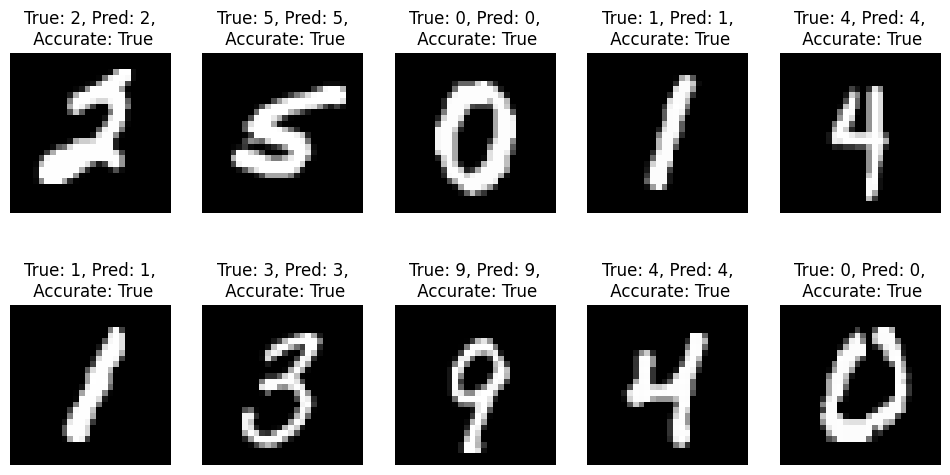

In [12]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто? -- помилок 0-2 з 10

# Місце для вашого коду
random_indices = np.random.choice(len(x_test), 10, replace=False)
random_images = x_test_img[random_indices]
random_labels = y_test[random_indices]
random_preds = neural_net(x_test[random_indices])
random_pred_labels = tf.argmax(random_preds, axis=1)

plt.figure(figsize=(12, 6))
for i, (image, true_label, pred_label) in enumerate(zip(random_images, random_labels, random_pred_labels)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'True: {true_label}, Pred: {pred_label},\n Accurate: {true_label==pred_label}')
    plt.axis('off')
plt.show()

In [14]:
from sklearn.metrics import classification_report

y_pred = neural_net(x_test)
y_pred_labels = tf.argmax(y_pred, axis=1).numpy()

for y_class in np.unique(y_test):
    indices = np.where(y_test == y_class)[0]
    y_class_true = y_test[indices]
    y_class_pred = y_pred_labels[indices]
    print(f"Class: {y_class}")
    print(classification_report(y_class_true, y_class_pred, labels=[y_class], target_names=[str(y_class)]))


    # найгірше розпізнаються 8 та 9. найкраще 1

Class: 0
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       980

   micro avg       1.00      0.95      0.98       980
   macro avg       1.00      0.95      0.98       980
weighted avg       1.00      0.95      0.98       980

Class: 1
              precision    recall  f1-score   support

           1       1.00      0.98      0.99      1135

   micro avg       1.00      0.98      0.99      1135
   macro avg       1.00      0.98      0.99      1135
weighted avg       1.00      0.98      0.99      1135

Class: 2
              precision    recall  f1-score   support

           2       1.00      0.89      0.94      1032

   micro avg       1.00      0.89      0.94      1032
   macro avg       1.00      0.89      0.94      1032
weighted avg       1.00      0.89      0.94      1032

Class: 3
              precision    recall  f1-score   support

           3       1.00      0.90      0.95      1010

   micro avg       1.00      0.90  